## Explore the impact of the number of steps per period on learning

In [18]:
# import libraries
import torch.nn as nn
import torch
import numpy as np
from forage_training import train_multiple_networks
from forage_analysis import plot_mean_perf_by_seq_len
import ngym_foraging as ngym_f
from ngym_foraging.wrappers import pass_reward, pass_action
import gym
import os

# global variables
# check if GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# name of the task on the neurogym library
TASK = 'ForagingBlocks-v0'

TRAINING_KWARGS = {'dt': 100,
                   'lr': 1e-2,
                   'n_epochs': 100,
                   'batch_size': 16,
                   'seq_len': 300,
                   'TASK': TASK}

In [19]:
# define parameters configuration
env_seed = 123
total_num_timesteps = 6000
num_periods = 2000
env_seed = 123
num_periods = 40
TRAINING_KWARGS['num_periods'] = num_periods
# create folder to save data based on env seed
main_folder = 'C:/Users/saraf/OneDrive/Documentos/IDIBAPS/foraging RNNs/nets/'
# main_folder = '/home/molano/foragingRNNs_data/nets/'
# Set up the task
w_factor = 0.00001
mean_ITI = 200
max_ITI = 400
fix_dur = 100
dec_dur = 100
blk_dur = 50
probs = np.array([0.1, 0.9])
num_epochs = 100 # ??
env_kwargs = {'dt': TRAINING_KWARGS['dt'], 'probs': probs,
              'blk_dur': blk_dur, 'timing':
                  {'ITI': ngym_f.random.TruncExp(mean_ITI, 100, max_ITI),
                    # mean, min, max
                    'fixation': fix_dur, 'decision': dec_dur},
                  # Decision period}
                  'rewards': {'abort': 0., 'fixation': 0., 'correct': 1.}}
TRAINING_KWARGS['classes_weights'] =\
    torch.tensor([w_factor*TRAINING_KWARGS['dt']/(mean_ITI),
                  w_factor*TRAINING_KWARGS['dt']/fix_dur, 2, 2])
# call function to sample
env = gym.make(TASK, **env_kwargs)
env = pass_reward.PassReward(env)
env = pass_action.PassAction(env)
# set seed
env.seed(env_seed)
env.reset()
net_kwargs = {'hidden_size': 128,
              'action_size': env.action_space.n,
              'input_size': env.observation_space.shape[0]}
TRAINING_KWARGS['env_kwargs'] = env_kwargs
TRAINING_KWARGS['net_kwargs'] = net_kwargs

# create folder to save data based on parameters
save_folder = (f"{main_folder}w{w_factor}_mITI{mean_ITI}_xITI{max_ITI}_f{fix_dur}_"
                f"d{dec_dur}_nb{np.round(blk_dur/1e3, 1)}_"
                f"prb{probs[0]}")

# create folder to save data based on env seed
os.makedirs(save_folder + 'n_pers_'+str(np.round(num_periods/1e3, 1))+'k_'+'s_'+str(env_seed),
            exist_ok=True)

# Save config as npz
np.savez(save_folder+'/config.npz', **TRAINING_KWARGS)

num_epochs = TRAINING_KWARGS['n_epochs']
num_steps_plot = 100
num_steps_test = 1000
debug = False
num_networks = 4
criterion = nn.CrossEntropyLoss(weight=TRAINING_KWARGS['classes_weights'])

c:\Users\saraf\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
c:\Users\saraf\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
c:\Users\saraf\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


c:\Users\saraf\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\saraf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


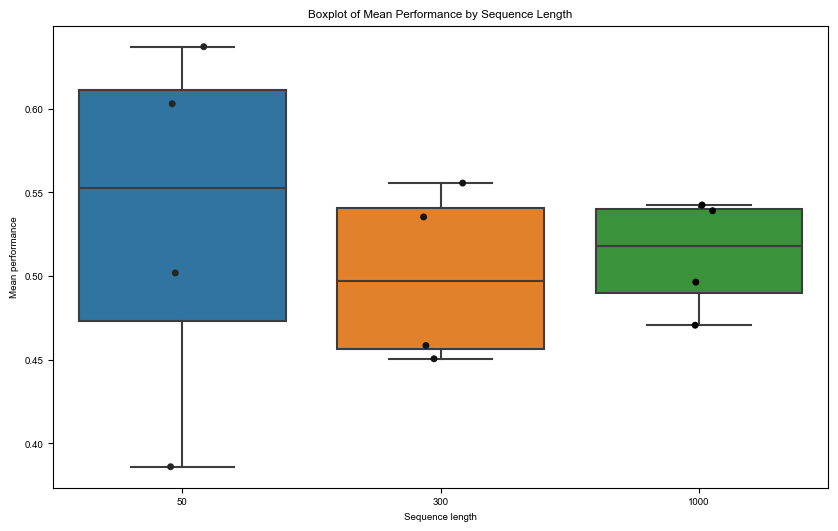

In [20]:
# define parameter to explore
seq_len_mat = np.array([50, 300, 1000])
mperf_lists = []
for seq_len in seq_len_mat:
  num_periods = total_num_timesteps // seq_len
  mperf_list, _ = train_multiple_networks(mean_ITI=mean_ITI, fix_dur=fix_dur, blk_dur=blk_dur,
                            num_networks=num_networks, env=env,
                            env_seed=env_seed, main_folder=main_folder, save_folder=save_folder,
                            env_kwargs=env_kwargs, net_kwargs=net_kwargs, criterion=criterion,
                            num_periods=num_periods, seq_len=seq_len)
  mperf_lists.append(mperf_list)
    
# plot performance
plot_mean_perf_by_seq_len(mperf_lists, seq_len_mat)